In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
import contextily as cx 
import geopandas as gpd
from shapely.geometry import Point

# %matplotlib inline
import glob

import osmnx as ox
import os


# # Import specific pandana loaders for direct control over network creation
# # from pandana.loaders import osm # We will replace this with direct OSMnx graph conversion
# from pandana.loaders.pandash5 import network_to_pandas_hdf5
# import pandana as pdna
# import geopandas as gpd
# from shapely.geometry import Point
# from shapely import wkt
 
# from random import sample
# from tqdm import tqdm # For progress bars

import warnings
warnings.filterwarnings('ignore')


In [2]:
CITY = '2559'

Traffic Light Travel Time Analysis
Data loaded successfully. Shape: (217871, 25)


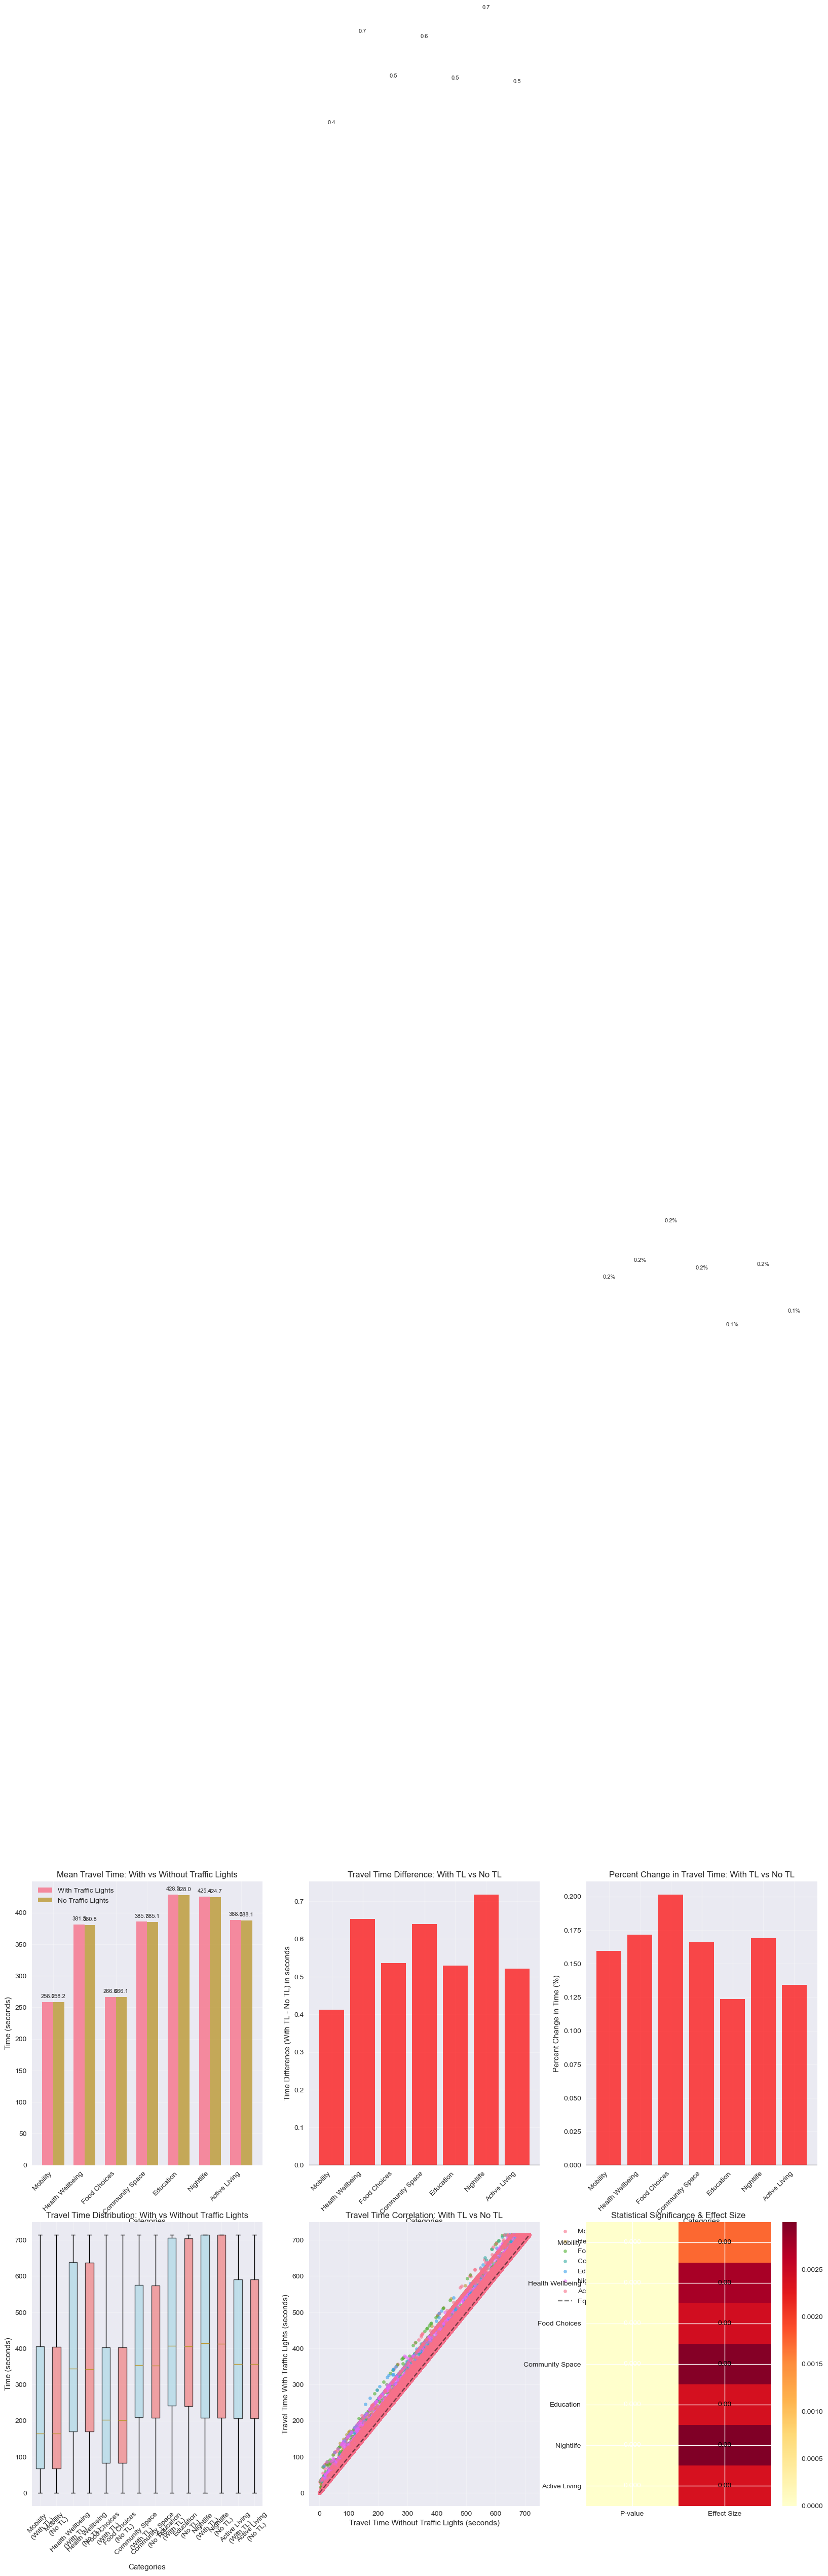


TRAVEL TIME COMPARISON SUMMARY: WITH vs WITHOUT TRAFFIC LIGHTS
        Category With TL (Mean Time) No TL (Mean Time) Difference (seconds) Percent Change (%)                    Impact
        Mobility              258.58            258.17                 0.41               0.2% Negative (Increased Time)
Health Wellbeing              381.49            380.83                 0.65               0.2% Negative (Increased Time)
    Food Choices              266.64            266.11                 0.54               0.2% Negative (Increased Time)
 Community Space              385.74            385.10                 0.64               0.2% Negative (Increased Time)
       Education              428.50            427.97                 0.53               0.1% Negative (Increased Time)
       Nightlife              425.37            424.65                 0.72               0.2% Negative (Increased Time)
   Active Living              388.60            388.07                 0.52              

In [3]:

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_analyze_data(file_path):
    """Load the Excel file and prepare data for analysis"""
    try:
        # Read the Excel file
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

def prepare_comparison_data(df):
    """Prepare data for with_tl vs no_tl comparison, focusing on time difference"""
    
    # Define the categories for comparison
    categories = [
        'mobility',
        'health_wellbeing', 
        'food_choices',
        'community_space',
        'education',
        'nightlife',
        'active_living'
    ]
    
    comparison_data = []
    
    for category in categories:
        with_tl_col = f"{category}_with_tl"
        no_tl_col = f"{category}_no_tl"
        
        if with_tl_col in df.columns and no_tl_col in df.columns:
            # Calculate statistics for time
            with_tl_mean = df[with_tl_col].mean()
            no_tl_mean = df[no_tl_col].mean()
            # Difference: With TL time - No TL time. Positive means increased time.
            difference = with_tl_mean - no_tl_mean
            # Percent change: ((With TL time - No TL time) / No TL time) * 100
            percent_change = ((with_tl_mean - no_tl_mean) / no_tl_mean) * 100
            
            comparison_data.append({
                'category': category.replace('_', ' ').title(),
                'with_tl': with_tl_mean,
                'no_tl': no_tl_mean,
                'difference': difference,
                'percent_change': percent_change,
                'with_tl_data': df[with_tl_col].values,
                'no_tl_data': df[no_tl_col].values
            })
    
    return comparison_data

def create_comparison_plots(comparison_data):
    """Create comprehensive comparison visualizations for time difference"""
    
    # Set up the figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Bar chart comparing means
    ax1 = plt.subplot(2, 3, 1)
    categories = [item['category'] for item in comparison_data]
    with_tl_means = [item['with_tl'] for item in comparison_data]
    no_tl_means = [item['no_tl'] for item in comparison_data]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, with_tl_means, width, label='With Traffic Lights', alpha=0.8)
    bars2 = ax1.bar(x + width/2, no_tl_means, width, label='No Traffic Lights', alpha=0.8)
    
    ax1.set_xlabel('Categories')
    ax1.set_ylabel('Time (seconds)') # Updated label
    ax1.set_title('Mean Travel Time: With vs Without Traffic Lights') # Updated title
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 2. Difference plot
    ax2 = plt.subplot(2, 3, 2)
    differences = [item['difference'] for item in comparison_data]
    # Red if time increased (diff > 0), Green if time decreased (diff < 0)
    colors = ['red' if diff > 0 else 'green' for diff in differences] 
    
    bars = ax2.bar(categories, differences, color=colors, alpha=0.7)
    ax2.set_xlabel('Categories')
    ax2.set_ylabel('Time Difference (With TL - No TL) in seconds') # Updated label
    ax2.set_title('Travel Time Difference: With TL vs No TL') # Updated title
    ax2.set_xticklabels(categories, rotation=45, ha='right')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, diff in zip(bars, differences):
        height = bar.get_height()
        # Adjust text position based on positive/negative difference
        ax2.text(bar.get_x() + bar.get_width()/2., height + (5 if height > 0 else -15),
                 f'{diff:.1f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    # 3. Percent change plot
    ax3 = plt.subplot(2, 3, 3)
    percent_changes = [item['percent_change'] for item in comparison_data]
    # Red if time increased (pc > 0), Green if time decreased (pc < 0)
    colors = ['red' if pc > 0 else 'green' for pc in percent_changes] 
    
    bars = ax3.bar(categories, percent_changes, color=colors, alpha=0.7)
    ax3.set_xlabel('Categories')
    ax3.set_ylabel('Percent Change in Time (%)') # Updated label
    ax3.set_title('Percent Change in Travel Time: With TL vs No TL') # Updated title
    ax3.set_xticklabels(categories, rotation=45, ha='right')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, pc in zip(bars, percent_changes):
        height = bar.get_height()
        # Adjust text position based on positive/negative percent change
        ax3.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -1),
                 f'{pc:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    # 4. Box plot comparison
    ax4 = plt.subplot(2, 3, 4)
    
    # Prepare data for box plot
    box_data = []
    box_labels = []
    
    for item in comparison_data:
        box_data.extend([item['with_tl_data'], item['no_tl_data']])
        box_labels.extend([f"{item['category']}\n(With TL)", f"{item['category']}\n(No TL)"])
    
    bp = ax4.boxplot(box_data, labels=box_labels, patch_artist=True)
    
    # Color the boxes alternately
    colors = ['lightblue', 'lightcoral'] * len(comparison_data)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.set_xlabel('Categories')
    ax4.set_ylabel('Time (seconds)') # Updated label
    ax4.set_title('Travel Time Distribution: With vs Without Traffic Lights') # Updated title
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    
    # 5. Scatter plot showing relationship
    ax5 = plt.subplot(2, 3, 5)
    
    for i, item in enumerate(comparison_data):
        ax5.scatter(item['no_tl_data'], item['with_tl_data'], 
                    alpha=0.6, label=item['category'], s=20)
    
    # Add diagonal line (y=x)
    min_val = min([min(item['no_tl_data']) for item in comparison_data])
    max_val = max([max(item['with_tl_data']) for item in comparison_data])
    ax5.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Equal values')
    
    ax5.set_xlabel('Travel Time Without Traffic Lights (seconds)') # Updated label
    ax5.set_ylabel('Travel Time With Traffic Lights (seconds)') # Updated label
    ax5.set_title('Travel Time Correlation: With TL vs No TL') # Updated title
    ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax5.grid(True, alpha=0.3)
    
    # 6. Statistical significance heatmap
    ax6 = plt.subplot(2, 3, 6)
    
    # Perform t-tests for each category
    p_values = []
    effect_sizes = []
    
    for item in comparison_data:
        # Paired t-test
        t_stat, p_val = stats.ttest_rel(item['with_tl_data'], item['no_tl_data'])
        p_values.append(p_val)
        
        # Cohen's d (effect size)
        pooled_std = np.sqrt(((len(item['with_tl_data']) - 1) * np.var(item['with_tl_data']) + 
                              (len(item['no_tl_data']) - 1) * np.var(item['no_tl_data'])) / 
                             (len(item['with_tl_data']) + len(item['no_tl_data']) - 2))
        cohens_d = (np.mean(item['with_tl_data']) - np.mean(item['no_tl_data'])) / pooled_std
        effect_sizes.append(abs(cohens_d))
    
    # Create heatmap data
    heatmap_data = np.array([p_values, effect_sizes]).T
    
    im = ax6.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
    ax6.set_xticks([0, 1])
    ax6.set_xticklabels(['P-value', 'Effect Size'])
    ax6.set_yticks(range(len(categories)))
    ax6.set_yticklabels(categories)
    ax6.set_title('Statistical Significance & Effect Size')
    
    # Add text annotations
    for i in range(len(categories)):
        ax6.text(0, i, f'{p_values[i]:.3f}', ha='center', va='center', 
                 color='white' if p_values[i] < 0.05 else 'black') # Changed significance threshold for text color
        ax6.text(1, i, f'{effect_sizes[i]:.2f}', ha='center', va='center',
                 color='white' if effect_sizes[i] > 0.5 else 'black')
    
    plt.colorbar(im, ax=ax6)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def generate_summary_statistics(comparison_data):
    """Generate summary statistics table for time difference"""
    
    print("\n" + "="*80)
    print("TRAVEL TIME COMPARISON SUMMARY: WITH vs WITHOUT TRAFFIC LIGHTS") # Updated title
    print("="*80)
    
    df_summary = pd.DataFrame([
        {
            'Category': item['category'],
            'With TL (Mean Time)': f"{item['with_tl']:.2f}", # Updated column name
            'No TL (Mean Time)': f"{item['no_tl']:.2f}",   # Updated column name
            'Difference (seconds)': f"{item['difference']:.2f}", # Updated column name
            'Percent Change (%)': f"{item['percent_change']:.1f}%", # Updated column name
            # Updated impact interpretation for time: positive difference means increased time (negative impact)
            'Impact': 'Negative (Increased Time)' if item['difference'] > 0 else 
                      'Positive (Decreased Time)' if item['difference'] < 0 else 'No Change'
        }
        for item in comparison_data
    ])
    
    print(df_summary.to_string(index=False))
    
    # Statistical tests summary
    print("\n" + "="*60)
    print("STATISTICAL ANALYSIS")
    print("="*60)
    
    for item in comparison_data:
        t_stat, p_val = stats.ttest_rel(item['with_tl_data'], item['no_tl_data'])
        significance = "Significant" if p_val < 0.05 else "Not Significant"
        
        print(f"\n{item['category']}:")
        print(f"    T-statistic: {t_stat:.3f}")
        print(f"    P-value: {p_val:.3f}")
        print(f"    Result: {significance} (α = 0.05)")

def main():
    """Main analysis function"""
    
    # You would replace this with your actual file path
    file_path = f"../data/processed/access/{CITY}_time_comparison.csv"
    
    print("Traffic Light Travel Time Analysis") # Updated title
    print("="*50)
    
    # For demonstration, I'll create sample data based on your headers
    df = load_and_analyze_data(file_path)
    
    # Analyze the data
    comparison_data = prepare_comparison_data(df)
    
    if comparison_data:
        # Create visualizations
        fig = create_comparison_plots(comparison_data)
        
        # Generate summary statistics
        generate_summary_statistics(comparison_data)
        
        print(f"\nAnalysis complete! Analyzed {len(comparison_data)} travel time categories.") # Updated text
        print("Charts have been displayed showing the comparison between travel time") # Updated text
        print("with and without traffic lights across all categories.") # Updated text
        
    else:
        print("No comparison data could be generated. Please check your data format.")

if __name__ == "__main__":
    main()

# Additional utility functions for specific analyses

def analyze_spatial_patterns(df):
    """Analyze spatial patterns in travel time differences""" # Updated description
    
    categories = ['mobility', 'health_wellbeing', 'food_choices', 'community_space', 
                  'education', 'nightlife', 'active_living']
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, category in enumerate(categories):
        with_tl_col = f"{category}_with_tl"
        no_tl_col = f"{category}_no_tl"
        
        if with_tl_col in df.columns and no_tl_col in df.columns:
            # Calculate difference
            df[f'{category}_diff'] = df[with_tl_col] - df[no_tl_col]
            
            # Create scatter plot
            scatter = axes[i].scatter(df['x'], df['y'], c=df[f'{category}_diff'], 
                                     cmap='RdBu', alpha=0.6, s=10) # RdBu is good for showing positive/negative differences
            axes[i].set_title(f'{category.replace("_", " ").title()}\nTime Difference') # Updated title
            axes[i].set_xlabel('X Coordinate')
            axes[i].set_ylabel('Y Coordinate')
            plt.colorbar(scatter, ax=axes[i])
    
    # Remove empty subplot if categories are less than 8
    if len(categories) < len(axes):
        for j in range(len(categories), len(axes)):
            axes[j].remove()
    
    plt.tight_layout()
    plt.show()

def correlation_analysis(df):
    """Analyze correlations between different travel time measures""" # Updated description
    
    # Select time columns
    time_cols = [col for col in df.columns if 'with_tl' in col or 'no_tl' in col]
    
    # Create correlation matrix
    corr_matrix = df[time_cols].corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title('Correlation Matrix: Travel Time Measures') # Updated title
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return corr_matrix


TRAVEL TIME MAPPING ANALYSIS
Data loaded successfully. Shape: (217871, 25)
Determined local CRS for city 2559.0: EPSG:32632

Selected Point Analysis (education):
Point ID: 5454755830
Coordinates: (512338.17, 5043049.56)
Travel time with traffic lights: 326.20 seconds
Travel time without traffic lights: 236.20 seconds
Impact (difference): 90.00 seconds
Percent increase: 38.1%

Creating travel time surface around selected point...
Using 4266 points within 2000m radius for surface interpolation
Generating travel time comparison maps...


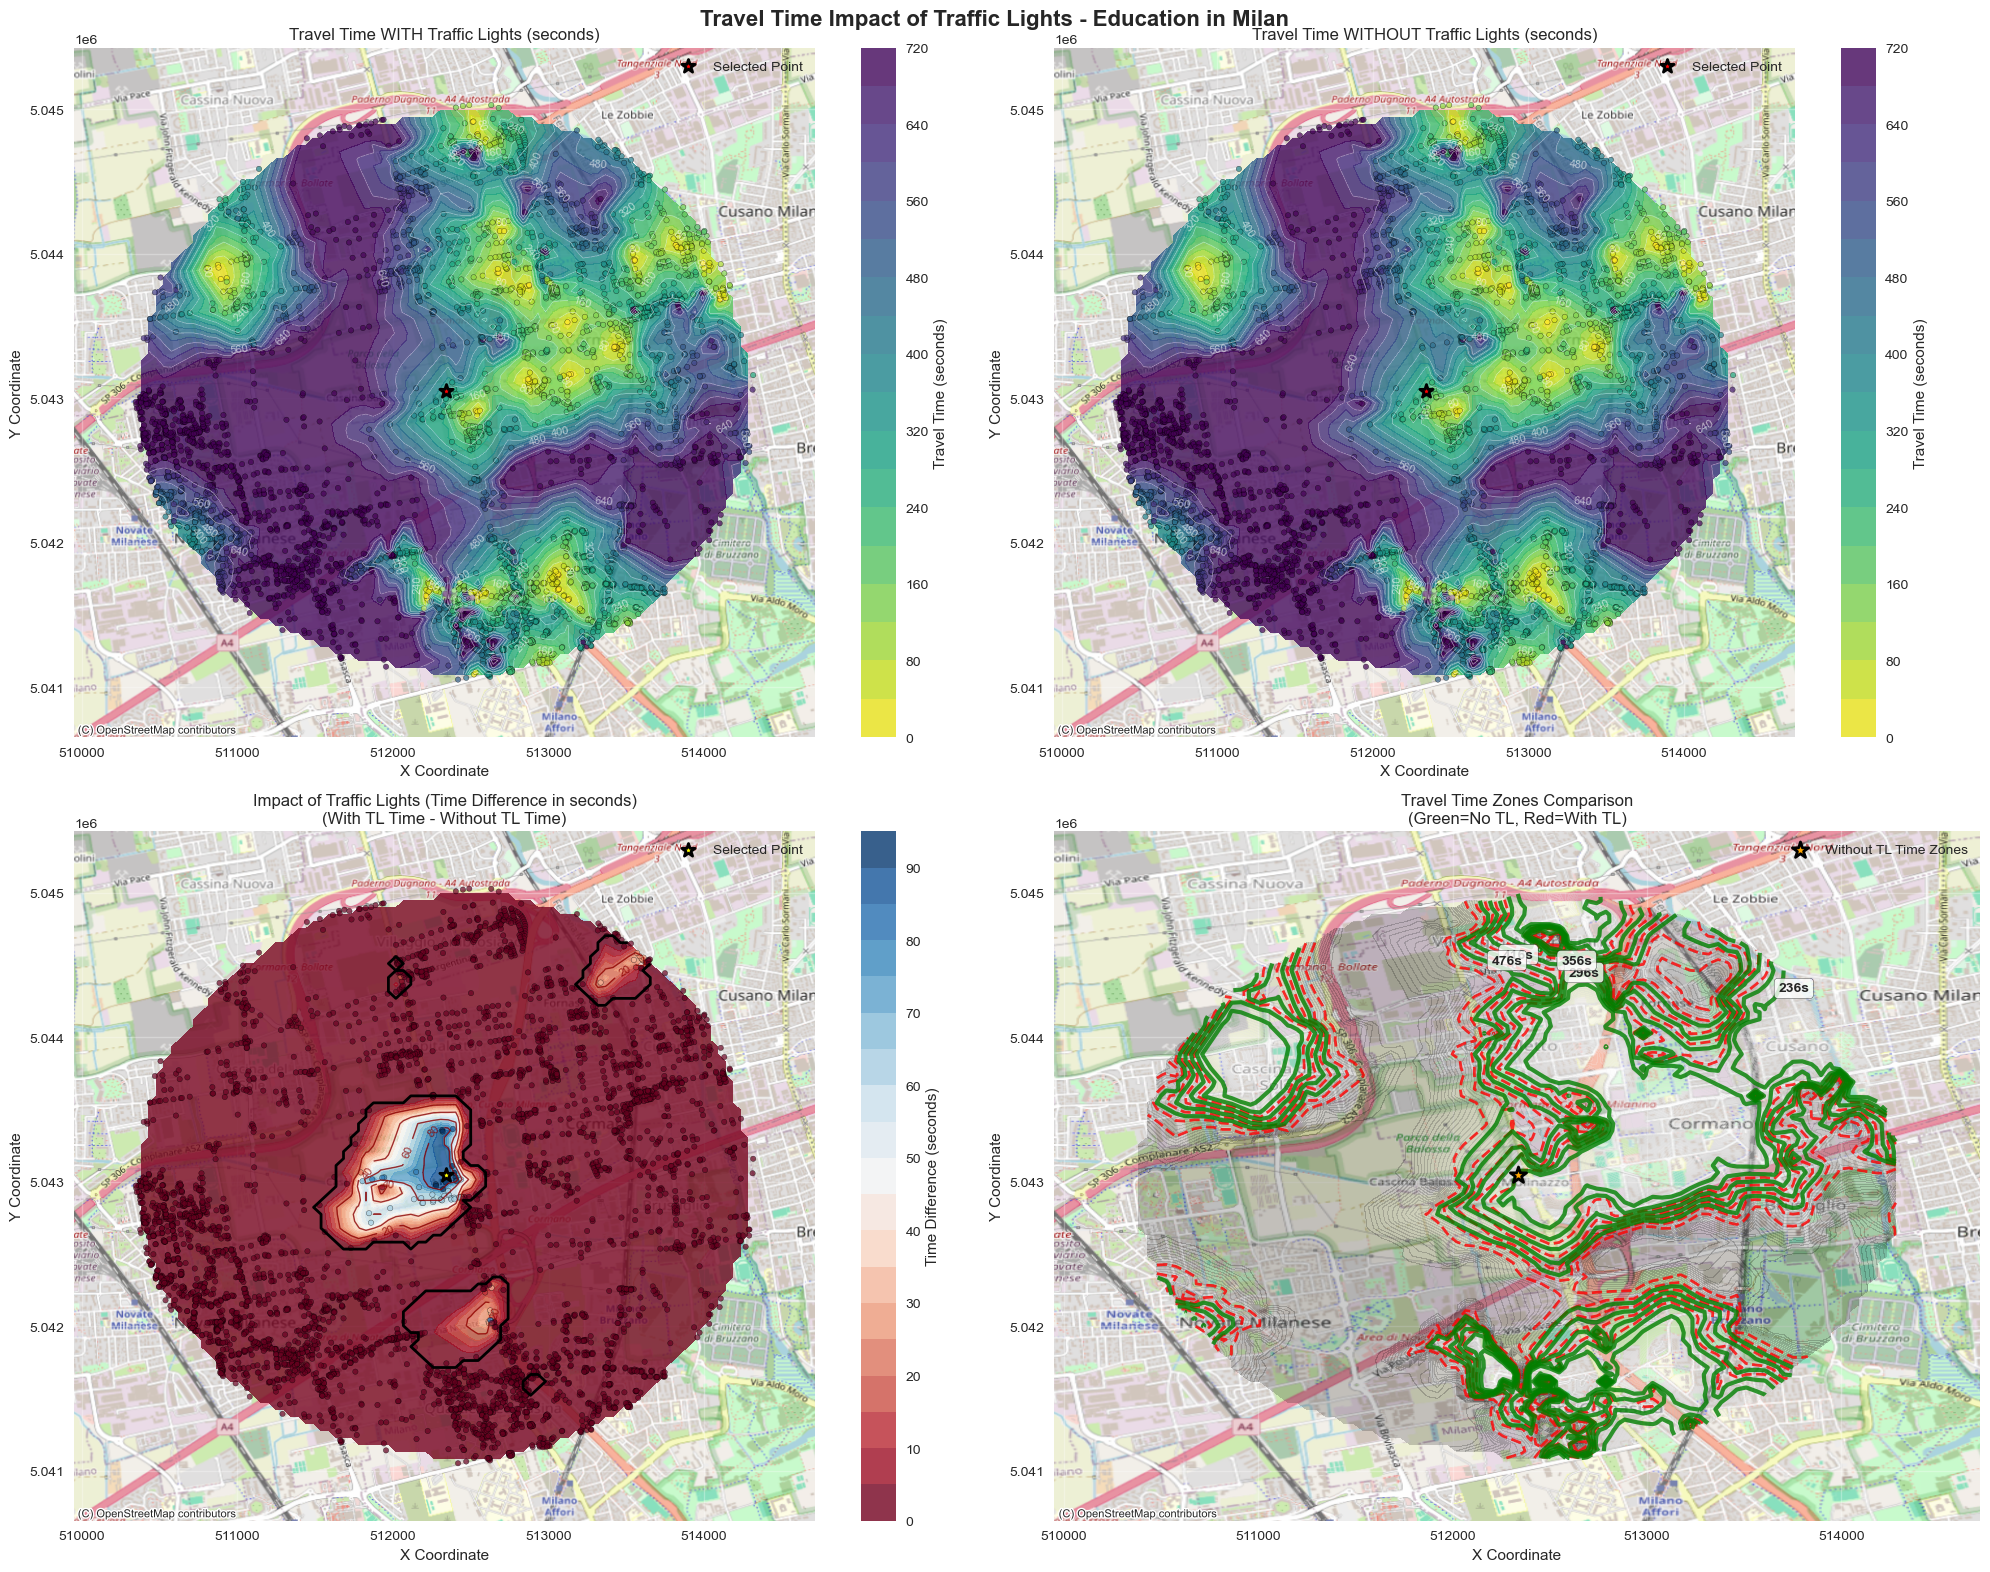


SPATIAL IMPACT ANALYSIS - EDUCATION
Area analyzed: 5283 grid cells
Average travel time increase: 2.73 seconds
Maximum travel time increase: 90.00 seconds
Minimum travel time change (could be decrease): 0.00 seconds
Standard deviation of time impact: 11.68 seconds

Spatial Impact Distribution (Travel Time):
Severe increase (>50s): 2.3% of area
Moderate increase (25-50s): 1.9% of area
Mild increase (0-25s): 5.1% of area
Decreased or no change (≤0s): 90.7% of area

Impact by Distance from Selected Point (Average Time Difference):
    0-500m: 23.16 seconds average impact (121 points)
    500-1000m: 0.62 seconds average impact (453 points)
    1000-1500m: 0.25 seconds average impact (1329 points)
    1500-2000m: 0.10 seconds average impact (2363 points)

Mapping analysis complete!
The maps show how traffic lights affect travel time around the selected point.
Red areas indicate increased travel time, green/blue areas indicate decreased travel time.


In [4]:
# --- Configuration Constants ---
WALKING_SPEED_MPS = 1.4 # meters per second, a typical average walking speed
TRAFFIC_LIGHT_DELAY_SECONDS = 30 # seconds, estimated average delay at a traffic light
MAX_DISTANCE = 1000 # Maximum distance in meters for accessibility queries

# Directory to save/load precomputed pandana networks
PANDANA_NETWORK_CACHE_DIR = "data/processed/pandana_networks"
os.makedirs(PANDANA_NETWORK_CACHE_DIR, exist_ok=True) # Ensure the directory exists

# Set working directory (adjust as needed)
# Ensure this directory exists and contains your data
directory = os.chdir(r'C:\Users\Guillermo\Documents\CSH\15_minute_city\city-access-map') # This line should be outside the script or handled differently for general use

def load_and_process_data(file_path):
    """Load Excel data, process, and prepare for mapping."""
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully. Shape: {df.shape}")

        if 'geometry' in df.columns and 'x' not in df.columns:
            df['x'] = df['geometry'].apply(lambda geom: wkt.loads(geom).x if isinstance(geom, str) else geom.x)
            df['y'] = df['geometry'].apply(lambda geom: wkt.loads(geom).y if isinstance(geom, str) else geom.y)

        # 1. Create a GeoDataFrame from your DataFrame
        geometry = [Point(xy) for xy in zip(df['x'], df['y'])]

        # Extract CRS from the first geometry in the original data to set the initial CRS
        # We assume the 'geometry' column in the CSV is in the *projected* CRS of the network data
        # which is typically a local UTM zone.
        # This requires `df['geometry']` to contain WKT strings that include CRS info if available,
        # or that the original `access` GeoDataFrame was saved with the CRS metadata intact.
        # If not, you might need to infer it from the city's location.
        # For this example, we'll assume the 'x' and 'y' extracted are already in the *local projected CRS*.
        # The CRS should be inferred or explicitly set from the original network data's CRS (graph_crs).
        
        # If your CSV's 'geometry' column contains WKT and the original GDF had a CRS,
        # you might be able to get it like this from the original saving process.
        # However, it's safer to pass the `graph_crs` obtained during network creation.
        
        # For demonstration purposes, let's assume the correct local CRS is stored in the `df` itself
        # (e.g., if it was saved as part of the CSV, which is not standard for CSV but possible if embedded)
        # or we need to pass it as an argument.
        # Since the previous script correctly used `graph_crs` for saving, we should try to
        # recover it or dynamically determine it.

        # For now, let's assume `df` already contains `crs` info or we'll get it from the file.
        # Since the CSV doesn't store CRS directly in a standard way, we need to infer it.
        # The previous script ensures `access` is saved with `graph_crs`.
        # A robust solution would be to load the GPKG of the city's urban center
        # and use its CRS, as the network is projected to match it.
        
        # In a real scenario, you would have `graph_crs` from the previous script run.
        # For this function, let's assume the 'access' dataframe saved to CSV
        # implicitly has `x` and `y` in the same projected CRS.
        # To avoid re-projecting to Web Mercator for plotting in local CRS, we *don't* reproject to EPSG:3857 here.

        # The CRS for the GeoDataFrame should be the *local projected CRS* of the network
        # that was used when the data was saved.
        # We need to know this CRS (e.g., EPSG:25831 for Barcelona, or dynamically for other cities).
        # Since we don't have the `graph_crs` directly in this function, we'll try to infer it from the city.
        
        # To make this robust, we should determine the city's specific UTM CRS.
        # For the provided data, we know `df` comes from `access` GeoDataFrame which was saved with `graph_crs`.
        # This means `df['x']` and `df['y']` are already in that local projected CRS.
        
        # Let's add a placeholder for the actual CRS.
        # In a real application, you'd load the `geo_uc` and get the CRS of the specific city's polygon.
        
        # This section is modified: No reprojection to EPSG:3857 for plotting in local CRS.
        # Instead, we define the CRS of the loaded data as its native projected CRS.
        
        # A more robust way to get the CRS:
        # We know the original `geo_uc` (urban center polygon) was in EPSG:4326 and then projected.
        # We can re-project the `urban_center_polygon` from the previous script to get its CRS.
        
        # Since we are loading from a CSV, we need to handle the CRS explicitly.
        # The best way is to know the source CRS. From the previous script, it's `graph_crs`.
        # If `df` came from `access.to_csv()`, `df['x']` and `df['y']` are already in that `graph_crs`.

        # We'll need the original `graph_crs` or be able to determine it for `cx.add_basemap`.
        # For now, let's pass a placeholder `local_crs` from outside if possible.
        # Or, as a temporary measure, we can load the `geo_uc` within this function
        # to get the projected CRS for the specific city.
        
        # To get the local CRS for the city, we can re-use `osmnx.project_graph` logic.
        # This requires the city's urban polygon.
        city_id = df.loc[0, 'ID_HDC_G0'] # Get the city ID from the loaded data
        
        # Load the urban center polygon to determine its projected CRS
        # This requires the original geo_uc data to be available
        geo_uc_file = "downloads/GHS_STAT_UCDB2015MT_GLOBE_R2019A/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg"
        if os.path.exists(geo_uc_file):
            temp_geo_uc = gpd.read_file(geo_uc_file)
            urban_center_polygon = temp_geo_uc[temp_geo_uc["ID_HDC_G0"] == city_id].geometry.iloc[0]
            
            # Create a dummy graph just to get the projected CRS
            # This is a bit inefficient but ensures we get the *exact* CRS OSMnx would use
            # without re-downloading the entire network.
            dummy_G = ox.graph.graph_from_polygon(urban_center_polygon, network_type='walk', retain_all=False)
            dummy_G_proj = ox.project_graph(dummy_G)
            local_crs = dummy_G_proj.graph['crs']
            print(f"Determined local CRS for city {city_id}: {local_crs}")
        else:
            print("Warning: Urban center GPKG not found. Cannot determine local CRS dynamically. Assuming common UTM CRS if applicable.")
            # Fallback if geo_uc_file is not available: Try to infer a common UTM or default.
            # This is less reliable. For Barcelona (ID 2051) it would be EPSG:25831.
            # For other cities, it would be different.
            local_crs = "EPSG:3857" # Fallback to Web Mercator for basemap if local CRS is unknown
                                    # but data is still plotted in its native coordinates.
                                    # This might lead to misaligned basemap if data is truly in a different projected CRS.

        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=local_crs)
        
        # Store the determined local_crs in the DataFrame for later use in plotting
        df['local_crs'] = local_crs

        return df
    except Exception as e:
        print(f"Error loading or processing file: {e}")
        return None

def select_most_affected_point(df, category='education'):
    """Select a point that's most negatively affected by traffic lights (increased time),
        with reasonable base travel time."""

    with_tl_col = f"{category}_with_tl"
    no_tl_col = f"{category}_no_tl"

    if with_tl_col in df.columns and no_tl_col in df.columns:
        # Calculate impact (positive difference means traffic lights increase time)
        df['impact'] = df[with_tl_col] - df[no_tl_col]

        # Filter for points where impact is positive (time is increased)
        # And ensure the 'no_tl' time is not too low (e.g., > 60 seconds)
        # to ensure the percentage increase is meaningful and not due to already very short times
        candidate_points = df[(df['impact'] > 0) & (df[no_tl_col] > 60)].copy()

        if not candidate_points.empty:
            # Find the point with the largest positive impact (most increased time)
            most_affected_idx = candidate_points['impact'].idxmax() # Changed to idxmax for positive impact
            selected_point = df.loc[most_affected_idx]

            print(f"\nSelected Point Analysis ({category}):")
            print(f"Point ID: {selected_point.get('id', 'N/A')}")
            print(f"Coordinates: ({selected_point['x']:.2f}, {selected_point['y']:.2f})")
            print(f"Travel time with traffic lights: {selected_point[with_tl_col]:.2f} seconds") # Updated text
            print(f"Travel time without traffic lights: {selected_point[no_tl_col]:.2f} seconds") # Updated text
            print(f"Impact (difference): {selected_point['impact']:.2f} seconds") # Updated text
            print(f"Percent increase: {(selected_point['impact']/selected_point[no_tl_col]*100):.1f}%") # Updated text

            return selected_point, most_affected_idx
        else:
            print(f"No suitable 'most affected' point found for category '{category}' with base time > 60. Falling back to simple idxmax().") # Updated text
            most_affected_idx = df['impact'].idxmax() # Still idxmax for largest increase
            selected_point = df.loc[most_affected_idx]

            print(f"\nSelected Point Analysis (fallback for {category}):")
            print(f"Point ID: {selected_point.get('id', 'N/A')}")
            print(f"Coordinates: ({selected_point['x']:.2f}, {selected_point['y']:.2f})")
            print(f"Travel time with traffic lights: {selected_point[with_tl_col]:.2f} seconds") # Updated text
            print(f"Travel time without traffic lights: {selected_point[no_tl_col]:.2f} seconds") # Updated text
            print(f"Impact (difference): {selected_point['impact']:.2f} seconds") # Updated text
            print(f"Percent increase: {(selected_point['impact']/selected_point[no_tl_col]*100):.1f}%") # Updated text

            return selected_point, most_affected_idx

    return None, None

def create_time_surface(df, center_point, category='education', method='distance_weighted'): # Renamed function
    """Create travel time surface around a center point""" # Updated description

    with_tl_col = f"{category}_with_tl"
    no_tl_col = f"{category}_no_tl"

    # Define the area around the center point
    center_x, center_y = center_point['x'], center_point['y']

    # Filter points within a reasonable distance (e.g., 2km radius)
    max_distance = 2000 # meters
    df['distance_to_center'] = np.sqrt((df['x'] - center_x)**2 + (df['y'] - center_y)**2)
    nearby_points = df[df['distance_to_center'] <= max_distance].copy()

    print(f"Using {len(nearby_points)} points within {max_distance}m radius for surface interpolation")

    if method == 'distance_weighted':
        # Create travel time surfaces using distance-weighted interpolation

        # Create grid for interpolation
        x_min, x_max = nearby_points['x'].min(), nearby_points['x'].max()
        y_min, y_max = nearby_points['y'].min(), nearby_points['y'].max()

        # Extend grid slightly beyond data points
        x_range = x_max - x_min
        y_range = y_max - y_min
        x_min -= x_range * 0.1
        x_max += x_range * 0.1
        y_min -= y_range * 0.1
        y_max += y_range * 0.1

        # Create grid
        grid_resolution = 100
        xi = np.linspace(x_min, x_max, grid_resolution)
        yi = np.linspace(y_min, y_max, grid_resolution)
        xi_grid, yi_grid = np.meshgrid(xi, yi)

        # Interpolate travel time surfaces
        points = nearby_points[['x', 'y']].values

        # With traffic lights
        values_with_tl = nearby_points[with_tl_col].values
        surface_with_tl = griddata(points, values_with_tl, (xi_grid, yi_grid), method='linear')

        # Without traffic lights
        values_no_tl = nearby_points[no_tl_col].values
        surface_no_tl = griddata(points, values_no_tl, (xi_grid, yi_grid), method='linear')

        # Calculate difference surface
        surface_difference = surface_with_tl - surface_no_tl

        return {
            'xi_grid': xi_grid,
            'yi_grid': yi_grid,
            'surface_with_tl': surface_with_tl,
            'surface_no_tl': surface_no_tl,
            'surface_difference': surface_difference,
            'nearby_points': nearby_points,
            'center_x': center_x,
            'center_y': center_y,
            'local_crs': center_point['local_crs'] # Pass the local CRS here
        }

    return None

def create_isochrone_zones(surface_data, center_point, category='education'):
    """Create isochrone-like zones based on travel time levels.""" # Updated description

    center_time_with = center_point[f"{category}_with_tl"]
    center_time_no = center_point[f"{category}_no_tl"]

    # Define time zones (e.g., maximum travel time thresholds)
    # These levels should be increasing for contour plots to work correctly
    # Let's define them relative to the *mean* travel time without TL,
    # or a fixed set of meaningful time thresholds.

    # Example: zones representing "within X seconds"
    # Starting from a reasonable base time, and increasing
    base_time_threshold = 300 # seconds, e.g., 5 minutes
    time_increments = [0, 60, 120, 180, 240] # Add 0 for the base

    # Generate zones based on the center point's 'no_tl' time,
    # ensuring they are increasing and positive.
    zones_no_tl = [center_time_no + inc for inc in time_increments]
    zones_with_tl = [center_time_with + inc for inc in time_increments]

    # Ensure levels are strictly increasing and unique for contour function
    zones_with_tl = np.unique(np.array(zones_with_tl)[np.array(zones_with_tl) > 0])
    zones_no_tl = np.unique(np.array(zones_no_tl)[np.array(zones_no_tl) > 0])

    # Sort them in ascending order
    zones_with_tl = np.sort(zones_with_tl)
    zones_no_tl = np.sort(zones_no_tl)

    return zones_with_tl, zones_no_tl

def plot_time_comparison_map(surface_data, center_point, category='education'): # Renamed function
    """Create comprehensive travel time comparison map with basemaps.""" # Updated description

    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    city_name = center_point['UC_NM_MN'] # Get city name from the selected point data
    fig.suptitle(f'Travel Time Impact of Traffic Lights - {category.replace("_", " ").title()} in {city_name}', # Updated title
                 fontsize=16, fontweight='bold')

    # Custom colormap for absolute time (lower time = better, e.g., green; higher time = worse, e.g., red)
    cmap_time = plt.cm.viridis_r

    # Colormap for difference (With TL - No TL): Red for positive (increase in time), Blue for negative (decrease in time)
    cmap_difference = 'RdBu'

    # Retrieve the local CRS determined in load_and_process_data
    local_crs_for_plotting = surface_data['local_crs']
    
    # 1. Travel Time WITH traffic lights
    ax1 = axes[0, 0]
    im1 = ax1.contourf(surface_data['xi_grid'], surface_data['yi_grid'],
                       surface_data['surface_with_tl'], levels=20, cmap=cmap_time, alpha=0.8)

    # Add contour lines
    cs1 = ax1.contour(surface_data['xi_grid'], surface_data['yi_grid'],
                      surface_data['surface_with_tl'], levels=10, colors='white', alpha=0.6, linewidths=0.5)
    ax1.clabel(cs1, inline=True, fontsize=8, fmt='%d')

    # Plot data points
    scatter1 = ax1.scatter(surface_data['nearby_points']['x'], surface_data['nearby_points']['y'],
                           c=surface_data['nearby_points'][f'{category}_with_tl'],
                           cmap=cmap_time, s=15, alpha=0.7, edgecolors='black', linewidths=0.3)

    # Highlight center point
    ax1.scatter(surface_data['center_x'], surface_data['center_y'],
                color='red', s=100, marker='*', edgecolors='black', linewidths=2,
                label='Selected Point', zorder=5)

    ax1.set_title('Travel Time WITH Traffic Lights (seconds)')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.colorbar(im1, ax=ax1, label='Travel Time (seconds)')
    # Use the local CRS for adding the basemap
    cx.add_basemap(ax1, crs=local_crs_for_plotting, source=cx.providers.OpenStreetMap.Mapnik)


    # 2. Travel Time WITHOUT traffic lights
    ax2 = axes[0, 1]
    im2 = ax2.contourf(surface_data['xi_grid'], surface_data['yi_grid'],
                       surface_data['surface_no_tl'], levels=20, cmap=cmap_time, alpha=0.8)

    cs2 = ax2.contour(surface_data['xi_grid'], surface_data['yi_grid'],
                      surface_data['surface_no_tl'], levels=10, colors='white', alpha=0.6, linewidths=0.5)
    ax2.clabel(cs2, inline=True, fontsize=8, fmt='%d')

    scatter2 = ax2.scatter(surface_data['nearby_points']['x'], surface_data['nearby_points']['y'],
                           c=surface_data['nearby_points'][f'{category}_no_tl'],
                           cmap=cmap_time, s=15, alpha=0.7, edgecolors='black', linewidths=0.3)

    ax2.scatter(surface_data['center_x'], surface_data['center_y'],
                color='red', s=100, marker='*', edgecolors='black', linewidths=2,
                label='Selected Point', zorder=5)

    ax2.set_title('Travel Time WITHOUT Traffic Lights (seconds)')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.colorbar(im2, ax=ax2, label='Travel Time (seconds)')
    cx.add_basemap(ax2, crs=local_crs_for_plotting, source=cx.providers.OpenStreetMap.Mapnik)


    # 3. Difference map (Impact of traffic lights)
    ax3 = axes[1, 0]
    im3 = ax3.contourf(surface_data['xi_grid'], surface_data['yi_grid'],
                       surface_data['surface_difference'], levels=20, cmap=cmap_difference, alpha=0.8)

    # Contour for zero difference
    cs3 = ax3.contour(surface_data['xi_grid'], surface_data['yi_grid'],
                      surface_data['surface_difference'], levels=[0], colors='black', linewidths=2)

    # Additional contours for positive values (increased time)
    cs3_pos = ax3.contour(surface_data['xi_grid'], surface_data['yi_grid'],
                          surface_data['surface_difference'], levels=[20, 40, 60, 80],
                          colors='darkred', alpha=0.8, linewidths=1)
    ax3.clabel(cs3_pos, inline=True, fontsize=8, fmt='%d')

    surface_data['nearby_points']['difference'] = (surface_data['nearby_points'][f'{category}_with_tl'] -
                                                  surface_data['nearby_points'][f'{category}_no_tl'])

    scatter3 = ax3.scatter(surface_data['nearby_points']['x'], surface_data['nearby_points']['y'],
                           c=surface_data['nearby_points']['difference'],
                           cmap=cmap_difference, s=15, alpha=0.7, edgecolors='black', linewidths=0.3)

    ax3.scatter(surface_data['center_x'], surface_data['center_y'],
                color='yellow', s=100, marker='*', edgecolors='black', linewidths=2,
                label='Selected Point', zorder=5)

    ax3.set_title('Impact of Traffic Lights (Time Difference in seconds)\n(With TL Time - Without TL Time)')
    ax3.set_xlabel('X Coordinate')
    ax3.set_ylabel('Y Coordinate')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    plt.colorbar(im3, ax=ax3, label='Time Difference (seconds)')
    cx.add_basemap(ax3, crs=local_crs_for_plotting, source=cx.providers.OpenStreetMap.Mapnik)


    # 4. Isochrone-style zones comparison
    ax4 = axes[1, 1]

    # Create travel time zones (isochrones)
    center_time_with = center_point[f'{category}_with_tl']
    center_time_no = center_point[f'{category}_no_tl']

    # Define zone levels and ensure they are strictly increasing
    zone_levels_with, zone_levels_no = create_isochrone_zones(surface_data, center_point, category)

    # Plot zones for WITHOUT traffic lights (shorter time, so "larger" area for a given time)
    cs_zones_no = ax4.contour(surface_data['xi_grid'], surface_data['yi_grid'],
                              surface_data['surface_no_tl'], levels=zone_levels_no,
                              colors=['green'], linestyles='-', linewidths=3, alpha=0.8)

    # Plot zones for WITH traffic lights (longer time, so "smaller" area for a given time)
    cs_zones_with = ax4.contour(surface_data['xi_grid'], surface_data['yi_grid'],
                                 surface_data['surface_with_tl'], levels=zone_levels_with,
                                 colors=['red'], linestyles='--', linewidths=2, alpha=0.8)

    # Fill background with light time surface (e.g., based on no_tl for context)
    ax4.contourf(surface_data['xi_grid'], surface_data['yi_grid'],
                 surface_data['surface_no_tl'], levels=50, cmap='Greys', alpha=0.2)

    ax4.scatter(surface_data['center_x'], surface_data['center_y'],
                color='orange', s=150, marker='*', edgecolors='black', linewidths=2,
                label='Selected Point', zorder=5)

    ax4.set_title('Travel Time Zones Comparison\n(Green=No TL, Red=With TL)')
    ax4.set_xlabel('X Coordinate')
    ax4.set_ylabel('Y Coordinate')
    ax4.legend(['Without TL Time Zones', 'With TL Time Zones', 'Selected Point'])
    ax4.grid(True, alpha=0.3)

    # Add basemap
    cx.add_basemap(ax4, crs=local_crs_for_plotting, source=cx.providers.OpenStreetMap.Mapnik)

    # Add zone labels (adjusting for potentially fewer levels after unique())
    for i, level_no in enumerate(zone_levels_no):
        if len(cs_zones_no.collections) > i:
            try:
                contour_no = cs_zones_no.collections[i].get_paths()[0].vertices
                if len(contour_no) > 0:
                    sorted_contour = contour_no[contour_no[:,1].argsort()[::-1]]
                    label_x, label_y = sorted_contour[len(sorted_contour)//10]
                    ax4.text(label_x, label_y, f'{int(level_no)}s', fontsize=10, fontweight='bold',
                             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8), zorder=6)
            except Exception as e:
                pass

    plt.tight_layout()
    plt.show()

    return fig

def analyze_spatial_impact(surface_data, center_point, category='education'):
    """Analyze the spatial characteristics of traffic light impact on travel time"""

    print(f"\n{'='*60}")
    print(f"SPATIAL IMPACT ANALYSIS - {category.upper()}")
    print(f"{'='*60}")

    # Calculate statistics for the area
    valid_mask = ~np.isnan(surface_data['surface_difference'])
    if np.any(valid_mask):
        diff_values = surface_data['surface_difference'][valid_mask]

        print(f"Area analyzed: {np.sum(valid_mask)} grid cells")
        print(f"Average travel time increase: {np.mean(diff_values):.2f} seconds")
        print(f"Maximum travel time increase: {np.max(diff_values):.2f} seconds")
        print(f"Minimum travel time change (could be decrease): {np.min(diff_values):.2f} seconds")
        print(f"Standard deviation of time impact: {np.std(diff_values):.2f} seconds")

        # Calculate percentage of area with different impact levels (for time)
        severe_increase = np.sum(diff_values > 50) / len(diff_values) * 100
        moderate_increase = np.sum((diff_values > 25) & (diff_values <= 50)) / len(diff_values) * 100
        mild_increase = np.sum((diff_values > 0) & (diff_values <= 25)) / len(diff_values) * 100
        decrease_or_no_change = np.sum(diff_values <= 0) / len(diff_values) * 100

        print(f"\nSpatial Impact Distribution (Travel Time):")
        print(f"Severe increase (>50s): {severe_increase:.1f}% of area")
        print(f"Moderate increase (25-50s): {moderate_increase:.1f}% of area")
        print(f"Mild increase (0-25s): {mild_increase:.1f}% of area")
        print(f"Decreased or no change (≤0s): {decrease_or_no_change:.1f}% of area")

        # Distance analysis from center point
        nearby_points = surface_data['nearby_points']
        distance_bins = [0, 500, 1000, 1500, 2000] # Distance bins in meters

        print(f"\nImpact by Distance from Selected Point (Average Time Difference):")
        for i in range(len(distance_bins)-1):
            mask = ((nearby_points['distance_to_center'] >= distance_bins[i]) &
                            (nearby_points['distance_to_center'] < distance_bins[i+1]))
            if np.any(mask):
                subset = nearby_points[mask]
                avg_impact = (subset[f'{category}_with_tl'] - subset[f'{category}_no_tl']).mean()
                print(f"    {distance_bins[i]}-{distance_bins[i+1]}m: {avg_impact:.2f} seconds average impact ({len(subset)} points)")

def main_mapping_analysis(file_path, category='education'):
    """Main function to run the complete mapping analysis for travel time"""

    print("TRAVEL TIME MAPPING ANALYSIS")
    print("="*50)

    # Load data
    df = load_and_process_data(file_path)
    if df is None:
        print("Failed to load data. Using sample data for demonstration.")
        exit(1)

    # Select the most affected point
    selected_point, point_idx = select_most_affected_point(df, category)
    
    # Ensure selected_point includes 'local_crs' and 'UC_NM_MN'
    if selected_point is not None:
        selected_point['local_crs'] = df['local_crs'].iloc[0] # Get the CRS from the processed df
        selected_point['UC_NM_MN'] = df['UC_NM_MN'].iloc[0] # Get the city name from the processed df

    if selected_point is None:
        print(f"Could not find travel time data for category: {category}")
        return

    # Create travel time surface
    print(f"\nCreating travel time surface around selected point...")
    surface_data = create_time_surface(df, selected_point, category)

    if surface_data is None:
        print("Failed to create travel time surface")
        return

    # Create the comprehensive map
    print(f"Generating travel time comparison maps...")
    fig = plot_time_comparison_map(surface_data, selected_point, category)

    # Analyze spatial impact
    analyze_spatial_impact(surface_data, selected_point, category)

    print(f"\nMapping analysis complete!")
    print(f"The maps show how traffic lights affect travel time around the selected point.")
    print(f"Red areas indicate increased travel time, green/blue areas indicate decreased travel time.")

if __name__ == "__main__":
    # Example usage:
    # Set working directory (adjust as needed)
    # Ensure this directory exists and contains your data
    # os.chdir(r'C:\Users\Guillermo\Documents\CSH\15_minute_city\city-access-map') # Uncomment and set your base directory

    # For demonstration, let's pick one of the cities processed in the previous script.
    # For instance, Milan (ID 2559) or Abuja (ID 2565)
    # Assuming you've run the previous script and generated these files.
    
    # You need to manually specify the city ID you want to visualize
    # or ensure your `df_keep` from the previous script is available.
    # For a direct example, let's use a hardcoded city ID that should have a corresponding CSV.
    
    file_path = f"data/processed/access/{CITY}_time_comparison.csv"
    category = "education" # Or "health_wellbeing", "food_choices", etc.

    # Check if the file exists before proceeding
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist. Please ensure the previous script has processed city ID {CITY} and saved the CSV.")
        exit(1)
    else:
        main_mapping_analysis(file_path, category)

Data loaded successfully. Shape: (217871, 25)


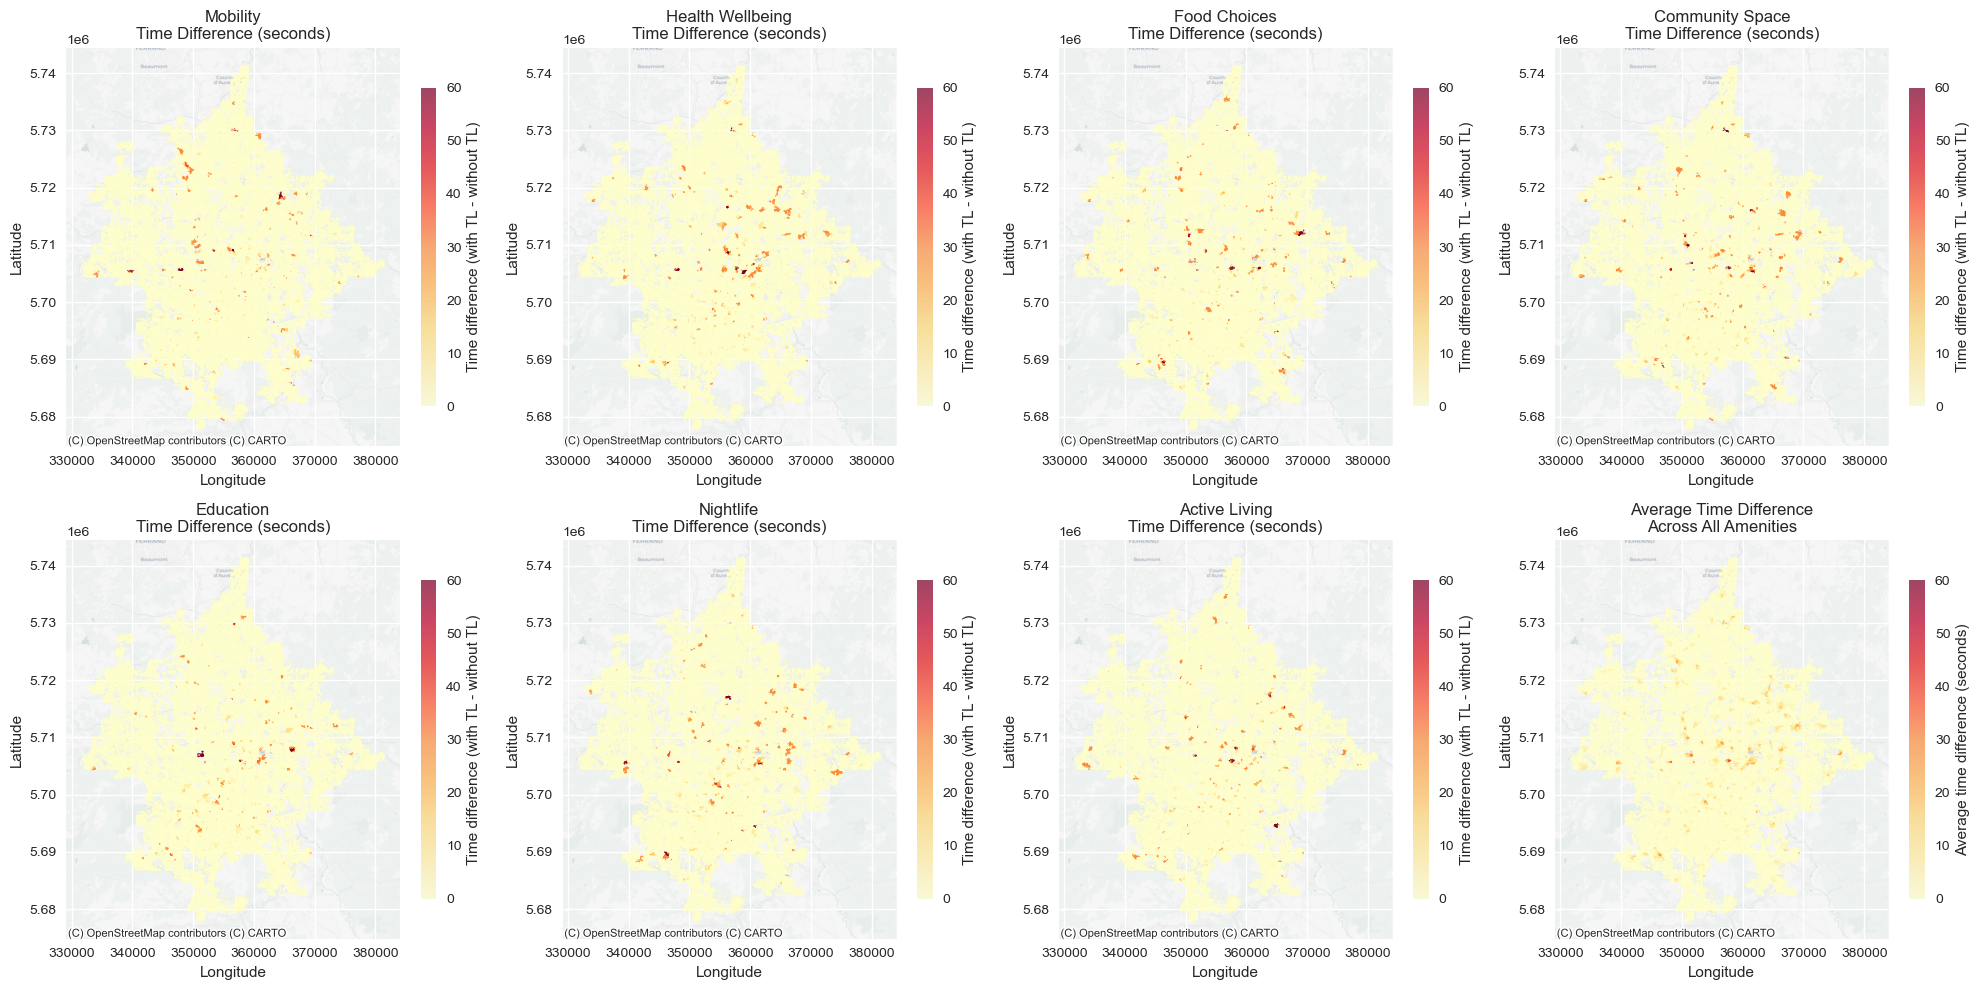

Summary Statistics for Milan:

Mobility:
  Mean difference: 0.41 seconds
  Std deviation: 3.51 seconds
  Max difference: 90.00 seconds
  Min difference: 0.00 seconds

Health Wellbeing:
  Mean difference: 0.65 seconds
  Std deviation: 4.27 seconds
  Max difference: 90.00 seconds
  Min difference: 0.00 seconds

Food Choices:
  Mean difference: 0.54 seconds
  Std deviation: 3.94 seconds
  Max difference: 90.00 seconds
  Min difference: 0.00 seconds

Community Space:
  Mean difference: 0.64 seconds
  Std deviation: 4.11 seconds
  Max difference: 87.68 seconds
  Min difference: 0.00 seconds

Education:
  Mean difference: 0.53 seconds
  Std deviation: 3.56 seconds
  Max difference: 90.00 seconds
  Min difference: 0.00 seconds

Nightlife:
  Mean difference: 0.72 seconds
  Std deviation: 4.43 seconds
  Max difference: 90.30 seconds
  Min difference: 0.00 seconds

Active Living:
  Mean difference: 0.52 seconds
  Std deviation: 3.85 seconds
  Max difference: 90.00 seconds
  Min difference: 0.00 

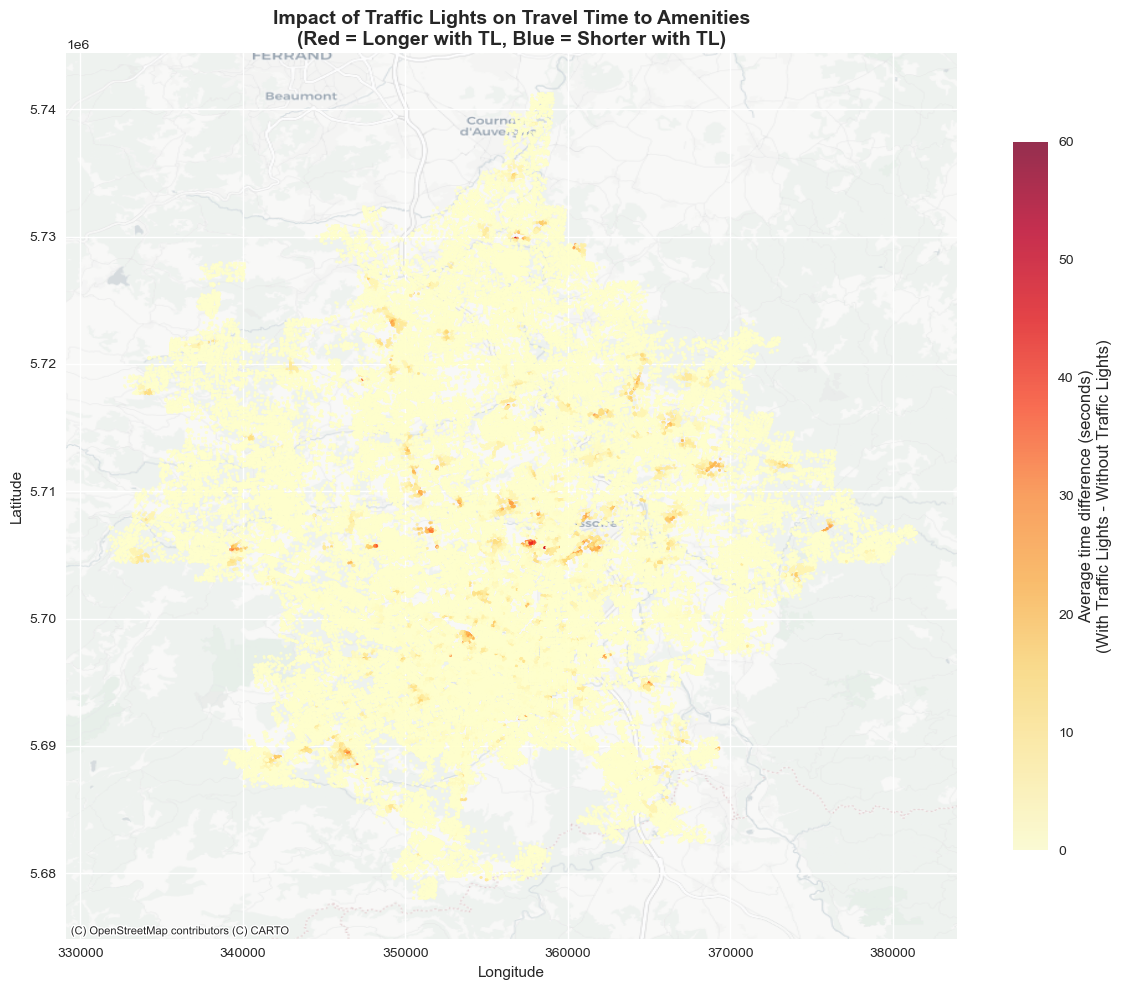

In [5]:

# Read the CSV file
df = load_and_analyze_data(file_path)
city_name = df.loc[0, 'UC_NM_MN']

# Create geometry column from x, y coordinates
geometry = [Point(xy) for xy in zip(df['x'], df['y'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:25831')

# Define amenity categories
amenities = ['mobility', 'health_wellbeing', 'food_choices', 'community_space', 
             'education', 'nightlife', 'active_living']

# Calculate time differences for each amenity (with_tl - no_tl)
# Positive values mean traffic lights increase travel time
for amenity in amenities:
    with_tl_col = f'{amenity}_with_tl'
    no_tl_col = f'{amenity}_no_tl'
    diff_col = f'{amenity}_diff'
    gdf[diff_col] = gdf[with_tl_col] - gdf[no_tl_col]

# Calculate overall average difference across all amenities
diff_columns = [f'{amenity}_diff' for amenity in amenities]
gdf['avg_diff'] = gdf[diff_columns].mean(axis=1)

# Convert to Web Mercator for basemap compatibility
gdf_web = gdf.to_crs('EPSG:3857')

# Create the plot
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Plot each amenity difference
for i, amenity in enumerate(amenities):
    ax = axes[i]
    diff_col = f'{amenity}_diff'
    
    # Create scatter plot with color mapping
    scatter = ax.scatter(gdf_web.geometry.x, gdf_web.geometry.y, 
                        c=gdf[diff_col], cmap='YlOrRd', 
                        s=1, alpha=0.7, vmin=0, vmax=60)
    
    # Add basemap
    cx.add_basemap(ax, crs=gdf_web.crs.to_string(), 
                    source=cx.providers.CartoDB.Positron, alpha=0.8)
    
    ax.set_title(f'{amenity.replace("_", " ").title()}\nTime Difference (seconds)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Time difference (with TL - without TL)')

# Plot average difference
ax = axes[7]
scatter = ax.scatter(gdf_web.geometry.x, gdf_web.geometry.y, 
                    c=gdf['avg_diff'], cmap='YlOrRd', 
                    s=1, alpha=0.7, vmin=0, vmax=60)

cx.add_basemap(ax, crs=gdf_web.crs.to_string(), 
                source=cx.providers.CartoDB.Positron, alpha=0.8)

ax.set_title('Average Time Difference\nAcross All Amenities')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Average time difference (seconds)')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Summary Statistics for {city_name}:")
print("=" * 50)
for amenity in amenities:
    diff_col = f'{amenity}_diff'
    mean_diff = gdf[diff_col].mean()
    std_diff = gdf[diff_col].std()
    max_diff = gdf[diff_col].max()
    min_diff = gdf[diff_col].min()
    
    print(f"\n{amenity.replace('_', ' ').title()}:")
    print(f"  Mean difference: {mean_diff:.2f} seconds")
    print(f"  Std deviation: {std_diff:.2f} seconds")
    print(f"  Max difference: {max_diff:.2f} seconds")
    print(f"  Min difference: {min_diff:.2f} seconds")

print(f"\nOverall Average Difference: {gdf['avg_diff'].mean():.2f} seconds")
print(f"Points where traffic lights increase time: {(gdf['avg_diff'] > 0).sum()}")
print(f"Points where traffic lights don't impact time: {(gdf['avg_diff'] == 0).sum()}")

# Optional: Create a single focused map for the average difference
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot with larger points for better visibility
scatter = ax.scatter(gdf_web.geometry.x, gdf_web.geometry.y, 
                    c=gdf['avg_diff'], cmap='YlOrRd', 
                    s=3, alpha=0.8, vmin=0, vmax=60)

# Add basemap
cx.add_basemap(ax, crs=gdf_web.crs.to_string(), 
                source=cx.providers.CartoDB.Positron, alpha=0.9)

ax.set_title('Impact of Traffic Lights on Travel Time to Amenities\n(Red = Longer with TL, Blue = Shorter with TL)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add colorbar with custom labels
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Average time difference (seconds)\n(With Traffic Lights - Without Traffic Lights)', 
               fontsize=12)

plt.tight_layout()
plt.show()

# Save the processed data if needed
# gdf.to_file('processed_traffic_light_data.gpkg', driver='GPKG')
# print("\nProcessed data saved to 'processed_traffic_light_data.gpkg'")

In [6]:
# # %matplotlib inline
# import glob
# import geopandas as gpd
# import pandas as pd
# import numpy as np
# import os
# import dask.dataframe as dd
# import matplotlib.pyplot as plt
# import time # Import the time module for performance measurement

# # Import specific pandana loaders for direct control over network creation
# # from pandana.loaders import osm # We will replace this with direct OSMnx graph conversion
# from pandana.loaders.pandash5 import network_to_pandas_hdf5
# import pandana as pdna
# import geopandas as gpd
# from shapely.geometry import Point
# from shapely import wkt
# import osmnx as ox # Explicitly import osmnx
# from random import sample
# from tqdm import tqdm # For progress bars

# # --- Configuration Constants ---
# WALKING_SPEED_MPS = 1.4 # meters per second, a typical average walking speed
# TRAFFIC_LIGHT_DELAY_SECONDS = 30 # seconds, estimated average delay at a traffic light
# MAX_DISTANCE = 1000 # Maximum distance in meters for accessibility queries

# # Directory to save/load precomputed pandana networks
# PANDANA_NETWORK_CACHE_DIR = "data/processed/pandana_networks"
# os.makedirs(PANDANA_NETWORK_CACHE_DIR, exist_ok=True) # Ensure the directory exists

# # Set working directory (adjust as needed)
# # Ensure this directory exists and contains your data
# directory = os.chdir(r'C:\Users\Guillermo\Documents\CSH\15_minute_city\city-access-map')

# print("loading data")
# # download POIs at https://github.com/MorbZ/OsmPoisPbf/ using uac_filter.txt
# # java -jar osmpois.jar --filterFile uac_filter.txt --printHeader planet.osm.pbf
# df = pd.read_csv("downloads/planet-250512.csv", sep='|')
# df = df[df.category.str.isnumeric()==True]
# df['category'] = df['category'].astype(float)
# df = df.rename(columns={"category": "poi_type_id"})

# poi_types = pd.read_excel("dataPreparation/poi_code_name_mapper.xlsx")
# poi_types = poi_types.replace(" ", np.NaN).dropna()

# df = df.merge(poi_types, on="poi_type_id")

# # download this data at http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_STAT_UCDB2015MT_GLOBE_R2019A/V1-2/
# uc = pd.read_csv("downloads/GHS_STAT_UCDB2015MT_GLOBE_R2019A/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.csv", encoding = "ISO-8859-1", engine='python')

# print("preparing data")
# uc = uc[['ID_HDC_G0', "CTR_MN_NM", "UC_NM_MN", "P15", "AREA"]].dropna()
# # city + country
# uc["UC_NM_CTR"] = uc["UC_NM_MN"] + ", " + uc["CTR_MN_NM"]

# # merge df with uc data
# gdf = gpd.GeoDataFrame(
#     df, geometry=gpd.points_from_xy(df.lon, df.lat)).set_crs(4326)

# geo_uc = gpd.read_file("downloads/GHS_STAT_UCDB2015MT_GLOBE_R2019A/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg")
# geo_uc = geo_uc[['ID_HDC_G0', "CTR_MN_NM", "UC_NM_MN", "P15", "AREA", "geometry"]].dropna()
# geo_uc["UC_NM_CTR"] = geo_uc["UC_NM_MN"] + ", " + geo_uc["CTR_MN_NM"]

# gdf = gdf.sjoin(geo_uc, how="inner")

# df = gdf

# # make df of ratio poi/pop to filter data
# df["count"] = 1
# df_poi_per_pop = df.groupby(["ID_HDC_G0", "UC_NM_CTR"]).agg({"P15":"mean", "count":"sum", "AREA":"mean"}).reset_index()
# df_poi_per_pop["poi_per_pop"] = df_poi_per_pop["count"]/df_poi_per_pop["P15"]
# df_poi_per_pop["poi_per_km2"] = df_poi_per_pop["count"]/df_poi_per_pop["AREA"]

# # list of urban centers to keep (at least 1 POI per km2)
# uc_keep = df_poi_per_pop[(df_poi_per_pop.poi_per_km2>=1)&(df_poi_per_pop["count"]>=20)].ID_HDC_G0.to_list()
# df_keep = df[df['ID_HDC_G0'].isin(uc_keep)]
